In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('./kaggle_house_pred_train.csv')
test_data = pd.read_csv('./kaggle_house_pred_test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
os.getcwd()

'/home/software/deep_learning/dive_into_deep_learning/第三章深度学习基础'

In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]  #iloc和loc的区别 索引和列名的区别

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(all_features.mean())
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [39]:
loss = gloss.L2Loss()
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net
def log_rmse(net, train_features, train_labels):
    # 将⼩于1 的值设成1，使得取对数时数值更稳定。
    clipped_preds = nd.clip(net(train_features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), train_labels.log()).mean())
    return rmse.asscalar()
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate,weight_decay, batch_size):
    train_ls, test_ls = [],[]
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    #train_iter = gData.DateLoader(gdata.ArrayDataset(train_features,train_labels),batch_size, shuffle = True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',{'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            trainer.step(batch_size)    
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


def get_k_fold_data(k, i, X, y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_dacay,batch_size):

    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_dacay,batch_size)
        train_l_sum += train_ls[-1]
        if i==0:
            gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse', range(1, num_epochs + 1), valid_ls,['train', 'valid'])
    print('fold %d, train rmse: %f, valid rmse: %f' % (i, train_ls[-1], valid_ls[-1]))


    return train_l_sum / k, valid_l_sum / k
         


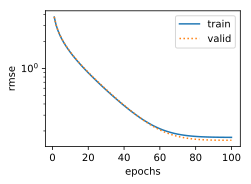

fold 4, train rmse: 0.162763, valid rmse: 0.182956
5-fold validation: avg train rmse: 0.165208, avg valid rmse: 0.000000


In [40]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
verbose_epoch = num_epochs - 2
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))   

In [13]:
sys.platform

'linux'

In [49]:
def train_and_pre(train_features,test_feature, train_labels,test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls,_ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    gb.semilogy(range(1, num_epochs+1), train_ls,'epochs', 'rmse' )
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

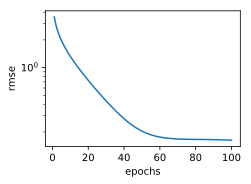

train rmse 0.162306


In [50]:
train_and_pre(train_features, test_features, train_labels, test_data, num_epochs, lr,weight_decay, batch_size)


In [ ]:
111S